<a href="https://colab.research.google.com/github/ericoandre/reconhecimento_padroes/blob/main/projeto_fava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!rm -R reconhecimento_padroes
!git clone https://github.com/ericoandre/reconhecimento_padroes.git

Cloning into 'reconhecimento_padroes'...
remote: Enumerating objects: 3252, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3252 (delta 2), reused 1 (delta 1), pack-reused 3249
Receiving objects: 100% (3252/3252), 1.55 GiB | 34.95 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (3668/3668), done.


# imports

In [24]:
import os

import numpy as np
from scipy.stats import uniform, randint, expon, loguniform
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import cv2
from imutils import paths

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, auc, roc_curve

# %tensorflow_version 2.x
from keras import backend as K
from keras.utils import np_utils
from keras.regularizers import l2
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
%matplotlib inline

# FUNÇÕES

In [25]:
def loadDataSet_(arg_dataset, myDepth=1):
  print("Path", arg_dataset)
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(arg_dataset))
  data  = []
  label = []
  
  for imagePath in imagePaths:
    target = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    if(myDepth == 1):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif myDepth== 0:
      image = np.ravel(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    data.append(image)
    label.append(target)

  data = np.array(data, dtype="float") / 255.0
  num_classes = len(list(set(label)))
  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(label)

  if 1 <= myDepth <=3:
    data = np.array(data).reshape((data.shape[0], data.shape[1], data.shape[2], myDepth))
    labels = np_utils.to_categorical(labels, num_classes)

  return (np.array(data), np.array(labels), label_encoder)

# Atributos

In [26]:
#Atributos
seed = 42
largura=200
altura=267
teste_size=0.3

np.random.seed(seed)

classes_label = ['fava cearense','orelha de vo']

scores_dict = dict()


## Plots

In [27]:
def testando(melhor_modelo, x_test, y_test, description, theme='Greens'):
  # Coletando predições
  y_prob = melhor_modelo.predict_proba(x_test)[:, 1] # probabilidades para a 2a classe
  y_pred = melhor_modelo.predict(x_test) # prediçoes discretas

  # calculando a acuracia, precisao e cobertura
  acuracia = accuracy_score(y_test, y_pred)
  precisao = precision_score(y_test, y_pred)
  cobertura = recall_score(y_test, y_pred) # Revocação (cobertura ou recall)
  f1_armonica = f1_score(y_test, y_pred)

  # calculando a curva
  curva_precisao, curva_cobertura, thresholds = precision_recall_curve(y_test, y_prob)

  # calculando a área sob a curva
  auc_precisao_cobertura = auc(curva_cobertura, curva_precisao)
  matrix_confusion = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = matrix_confusion.ravel()
  #matrix_confusion = np.array([[tp, fn], [fp, tn]])

  scores_dict[description] = [acuracia,auc_precisao_cobertura, precisao,cobertura,f1_armonica, (tn, fp, fn, tp)]

  # imprimindo
  print('----- ------------------------- -----')
  print("Acurácia de teste = {:.3f}".format(acuracia))
  print("AUC = {:.3f}".format(auc_precisao_cobertura))
  print("Precisão = {:.3f}, cobertura = {:.3f}".format(precisao, cobertura))
  print("F1 = {:.3f}".format(f1_armonica))
  print('----- ------------------------- -----')

  fpr, tpr, thresholds = roc_curve(y_test, y_prob) 


  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
  fig.suptitle(description)
  sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cmap=theme,cbar=False, ax=axes[0],xticklabels=classes_label, yticklabels=classes_label)
    
  axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
  axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
  axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
  axes[0].annotate('VP', (1.3,1.5), fontweight='bold')

  axes[1].plot(curva_cobertura, curva_precisao)
  axes[1].set_xlabel('')
  axes[1].set_ylabel('')

  axes[2].plot(fpr, tpr)
  axes[2].plot([0, 1], ls="--")
  axes[2].plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  axes[2].set_xlabel('True Positive Rate')
  axes[2].set_ylabel('False Positive Rate')
  plt.show()

# Modelos Simplies

## variaveis

In [29]:
arg_dataset = "reconhecimento_padroes/imagens_aumentada_mascara{}x{}".format(largura, altura)
X, y, encode = loadDataSet_(arg_dataset, myDepth=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=teste_size, random_state=seed)

Path reconhecimento_padroes/imagens_aumentada_mascara200x267
[INFO] loading images...


In [40]:
tree_parametros = {
    "tree__criterion": ["gini", "entropy"],
    "tree__splitter": ["best", "random"],
    "tree__min_samples_split": uniform(loc=0, scale=1),
    "tree__min_samples_leaf":  uniform(loc=1e-6, scale=0.5),
    "tree__max_leaf_nodes": randint(1, 1000),
    "tree__max_depth": randint(1, 1000),
}

knn_parametros = {
    "knn__n_neighbors": randint(1, 50),
}
mlp_params = {
    "mlp__hidden_layer_sizes": randint(1, 100),
    "mlp__activation": ["identity", "logistic", "tanh", "relu"],
    "mlp__learning_rate_init": expon(loc=1e-6, scale=0.1),
    "mlp__max_iter": randint(1, 1000),
    "mlp__momentum": uniform(loc=0.5,scale=0.4999),
    "mlp__solver" : ["lbfgs", "sgd", "adam"]
}
svm_params = {
    "svm__C": loguniform(1e-4, 1e2),
    "svm__kernel": ["poly","rbf","linear"],
    "svm__degree": randint(2,5),
    "svm__gamma": loguniform(1e-4, 1e2), 
}
gaussian_parametros = {
    'gaussian__var_smoothing': [1e-11, 1e-10, 1e-9]
}
interacao=10
kf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

## Classificadores

[INFO] NAIVE BAYES ... Best params: {'gaussian__var_smoothing': 1e-11}

----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       194
           1       0.74      0.70      0.72       219

    accuracy                           0.71       413
   macro avg       0.71      0.71      0.71       413
weighted avg       0.71      0.71      0.71       413

----- ------------------------- -----
Acurácia de teste = 0.712
AUC = 0.804
Precisão = 0.743, cobertura = 0.699
F1 = 0.720
----- ------------------------- -----


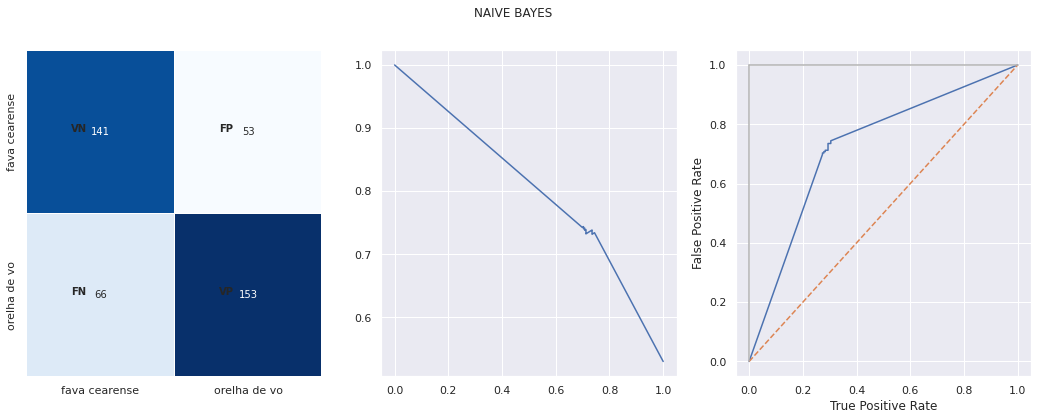

In [43]:
pipe = Pipeline([('scaler', StandardScaler()), ('gaussian', GaussianNB())])

gaussian_best_model = RandomizedSearchCV(pipe, gaussian_parametros, n_iter=3, cv=kf, refit=True)
gaussian_best_model = gaussian_best_model.fit(x_train, y_train)
gaussian_yfit = gaussian_best_model.predict(x_test)

description = "NAIVE BAYES"
# print(gaussian_best_model.best_estimator_)
print("[INFO] {} ... Best params: {}\n".format(description, gaussian_best_model.best_params_))
print('----- Evaluation on Test Data -----')
print(classification_report(y_test, gaussian_yfit))
testando(gaussian_best_model, x_test, y_test, description, 'Blues')

[INFO] DECISION TREE ... Best params: {'tree__criterion': 'entropy', 'tree__max_depth': 314, 'tree__max_leaf_nodes': 22, 'tree__min_samples_leaf': 0.003534152609858703, 'tree__min_samples_split': 0.023062425041415757, 'tree__splitter': 'best'}

----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       194
           1       0.79      0.80      0.80       219

    accuracy                           0.78       413
   macro avg       0.78      0.78      0.78       413
weighted avg       0.78      0.78      0.78       413

----- ------------------------- -----
Acurácia de teste = 0.785
AUC = 0.826
Precisão = 0.793, cobertura = 0.804
F1 = 0.798
----- ------------------------- -----


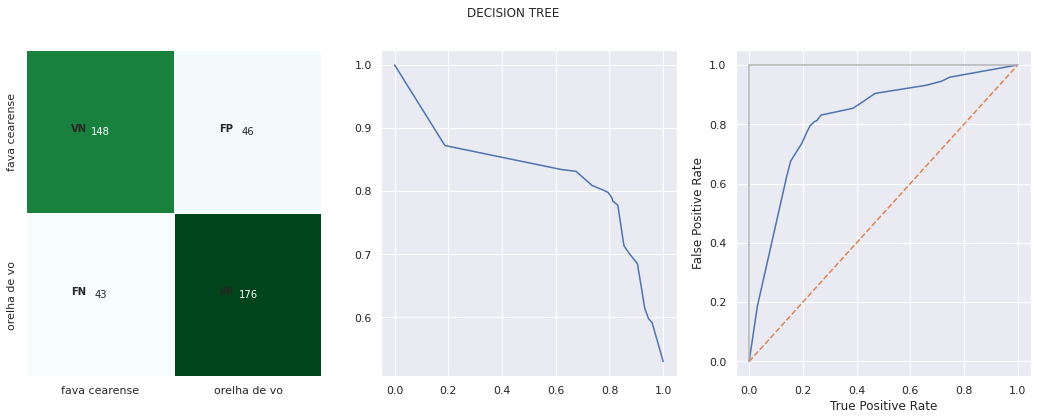

In [33]:
pipe = Pipeline([('scaler', StandardScaler()), ('tree', DecisionTreeClassifier())])

tree_best_model = RandomizedSearchCV(pipe, tree_parametros,n_iter=interacao, cv=kf, refit=True)
tree_best_model = tree_best_model.fit(x_train, y_train)
tree_yfit = tree_best_model.predict(x_test)

description = "DECISION TREE"
#print(tree_best_model.best_estimator_)
print("[INFO] {} ... Best params: {}\n".format(description, tree_best_model.best_params_))
print('----- Evaluation on Test Data -----')
print(classification_report(y_test, tree_yfit))
testando(tree_best_model, x_test, y_test, description, 'BuGn')

[INFO] KNN ... best params: {'knn__n_neighbors': 2}

----- Evaluation on Test Data -----
               precision    recall  f1-score   support

fava cearense       0.89      0.86      0.87       194
 orelha de vo       0.88      0.91      0.89       219

     accuracy                           0.88       413
    macro avg       0.88      0.88      0.88       413
 weighted avg       0.88      0.88      0.88       413

----- ------------------------- -----
Acurácia de teste = 0.884
AUC = 0.928
Precisão = 0.877, cobertura = 0.909
F1 = 0.892
----- ------------------------- -----


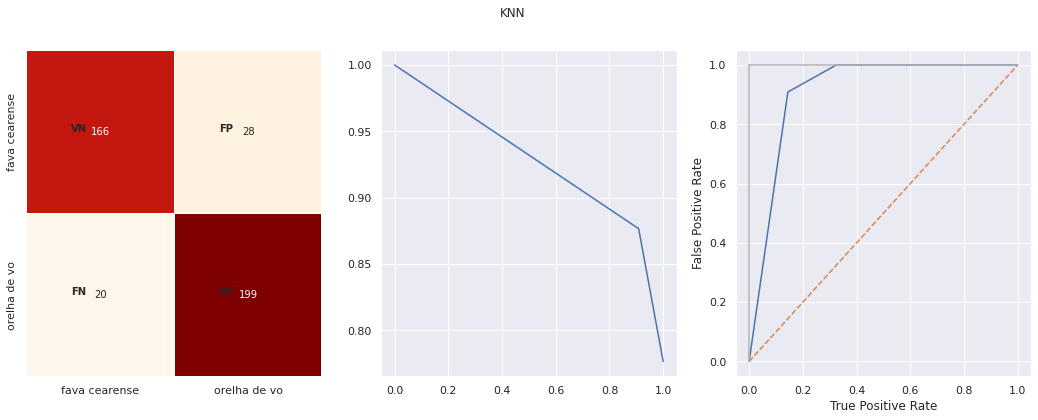

In [34]:
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_best_model = RandomizedSearchCV(pipe, knn_parametros, n_iter=interacao, cv=kf, refit=True)
knn_best_model = knn_best_model.fit(x_train, y_train)

knn_yfit = knn_best_model.predict(x_test)

description = "KNN"
# print(knn_best_model.best_estimator_)
print("[INFO] {} ... best params: {}\n".format(description, knn_best_model.best_params_))
print('----- Evaluation on Test Data -----')
print(classification_report(y_test, knn_yfit, target_names=classes_label))
testando(knn_best_model, x_test, y_test, description,'OrRd')

[INFO] SVM ... best params: {'svm__C': 3.311852292602025, 'svm__degree': 2, 'svm__gamma': 3.811537963782304, 'svm__kernel': 'poly'}

----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       194
           1       0.87      0.90      0.89       219

    accuracy                           0.88       413
   macro avg       0.88      0.88      0.88       413
weighted avg       0.88      0.88      0.88       413

----- ------------------------- -----
Acurácia de teste = 0.879
AUC = 0.953
Precisão = 0.872, cobertura = 0.904
F1 = 0.888
----- ------------------------- -----


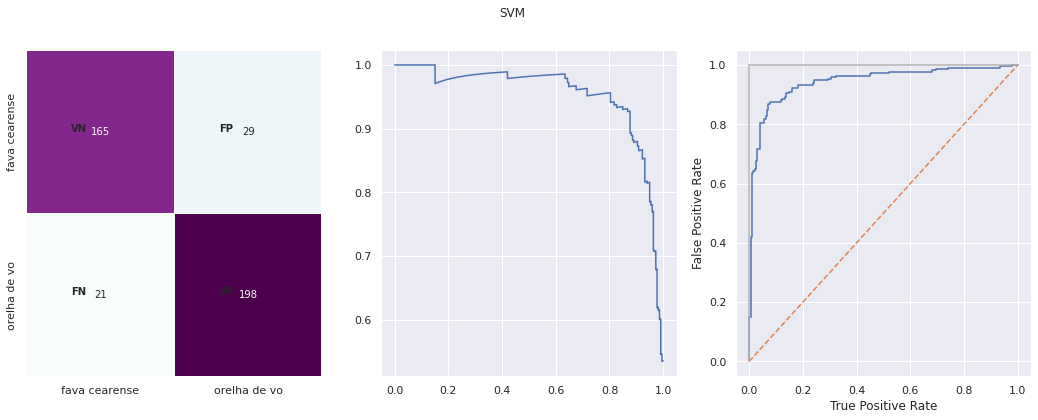

In [57]:
pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True))])
svm_best_model = RandomizedSearchCV(pipe, svm_params, n_iter=interacao, cv=kf, refit=True)
svm_best_model = svm_best_model.fit(x_train, y_train)

svm_yfit = svm_best_model.predict(x_test)

description = "SVM"
# print(svm_best_model.best_estimator_)
print("[INFO] {} ... best params: {}\n".format(description, svm_best_model.best_params_))
print('----- Evaluation on Test Data -----')
print(classification_report(y_test, svm_yfit))
testando(svm_best_model, x_test, y_test, description, 'BuPu') 

[INFO] MLP ... best params: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': 19, 'mlp__learning_rate_init': 0.08486518946848799, 'mlp__max_iter': 192, 'mlp__momentum': 0.8226716007239931, 'mlp__solver': 'lbfgs'}

----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       194
           1       0.94      0.96      0.95       219

    accuracy                           0.95       413
   macro avg       0.95      0.95      0.95       413
weighted avg       0.95      0.95      0.95       413

----- ------------------------- -----
Acurácia de teste = 0.947
AUC = 0.967
Precisão = 0.938, cobertura = 0.963
F1 = 0.950
----- ------------------------- -----


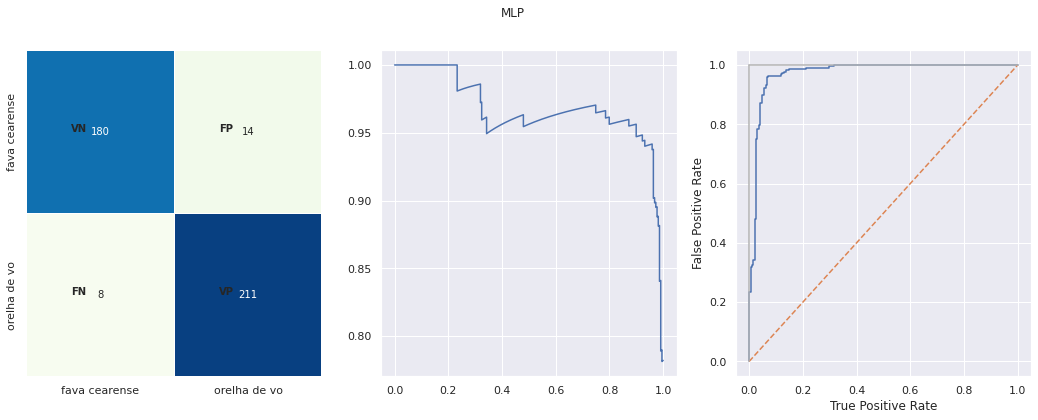

In [54]:
pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(early_stopping=True, validation_fraction=0.1))])
mlp_best_model = RandomizedSearchCV(pipe, mlp_params, n_iter=interacao, cv=kf, refit=True)
mlp_best_model = mlp_best_model.fit(x_train, y_train)

mpl_yfit = mlp_best_model.predict(x_test)

description = "MLP"
# print(mlp_best_model.best_estimator_)
print("[INFO] {} ... best params: {}\n".format(description, mlp_best_model.best_params_))
print('----- Evaluation on Test Data -----')
print(classification_report(y_test, mpl_yfit))
testando(mlp_best_model, x_test, y_test, description, 'GnBu')

# Modelos Deep Learn

## Funções

In [49]:
def modelo(width, height, depth, n_class, l2_penalty):
  model = Sequential()
  
  inputShape = (height, width, depth)
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
 
  model.add(Conv2D(256, (11, 11), input_shape=inputShape, padding="same", kernel_regularizer=l2_penalty))
  model.add(Activation("relu"))
  
  model.add(Conv2D(128, (5, 5), padding="same", kernel_regularizer=l2_penalty))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (5, 5), padding="same", kernel_regularizer=l2_penalty))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2_penalty))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  
  model.add(Dense(512, kernel_regularizer=l2_penalty))
  model.add(Activation("relu"))
  model.add(Dropout(0.12))
  model.add(Dense(n_class))
  model.add(Activation("softmax"))
  
  return model

In [50]:
def cria_model(largura, altura, custon_depth, label_encoder, arg_epochs, opt=None):
  print("[INFO] compiling model...")
  if(not opt):
    optimizer = Adam(learning_rate=1e-4, decay=1e-4 / arg_epochs)
  else:
    optimizer = SGD(learning_rate=1e-4, momentum=0.9)
  
  loss = 'binary_crossentropy'
  if len(label_encoder.classes_) > 2:
    loss = 'categorical_crossentropy'
    
  model = modelo(width=largura, height=altura, depth=custon_depth, n_class=len(label_encoder.classes_), l2_penalty=l2(0.0002))
  model.compile(loss=loss, optimizer=optimizer,metrics=["accuracy"])
  model.summary()
  return model

In [51]:
def treina_modelo(model, trainX, trainY, testX, testY, label_encoder, arg_epochs, custon_batch_size=32):
  print("[INFO] training network for {} epochs...".format(arg_epochs))
  H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=custon_batch_size, epochs=arg_epochs, verbose=1)
  print("[INFO] evaluating network...")
  predictions = model.predict(testX, batch_size=custon_batch_size)
  print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=classes_label))
  return (model, H)

In [52]:
def cnn_plot(model_cnn, H1, X_teste, y_teste, description):
  y_prob = model_cnn.predict(X_teste, batch_size=32, verbose = 0)[:, 1]
  y_pred = model_cnn.predict(X_teste)

  acuracia = accuracy_score(y_teste.argmax(axis=1), y_pred.argmax(axis=1))
  precisao = precision_score(y_teste.argmax(axis=1), y_pred.argmax(axis=1))
  cobertura = recall_score(y_teste.argmax(axis=1), y_pred.argmax(axis=1))
  f1_armonica = f1_score(y_teste.argmax(axis=1), y_pred.argmax(axis=1))

  curva_precisao, curva_cobertura, thresholds = precision_recall_curve(y_teste.argmax(axis=1), y_prob)
  auc_precisao_cobertura = auc(curva_cobertura, curva_precisao)

  matrix_confusion = confusion_matrix(y_teste.argmax(axis=1), y_pred.argmax(axis=1))
  tn, fp, fn, tp = matrix_confusion.ravel()
  fpr, tpr, thresholds = roc_curve(y_teste.argmax(axis=1), y_prob) 

  scores_dict[description] = [acuracia,auc_precisao_cobertura, precisao,cobertura,f1_armonica, (tn, fp, fn, tp)]


  # imprimindo
  print('----- ------------------------- -----')
  print("Acurácia de teste = {:.3f}".format(acuracia))
  print("AUC = {:.3f}".format(auc_precisao_cobertura))
  print("Precisão = {:.3f}, cobertura = {:.3f}".format(precisao, cobertura))
  print("F1 = {:.3f}".format(f1_armonica))
  print('----- ------------------------- -----')

  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
  fig.suptitle(description) # "CNN"


  sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cbar=False, ax=axes[0],xticklabels=classes_label, yticklabels=classes_label)
      
  axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
  axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
  axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
  axes[0].annotate('VP', (1.3,1.5), fontweight='bold')

  axes[1].plot(curva_cobertura, curva_precisao)
  axes[1].set_xlabel('')
  axes[1].set_ylabel('')

  axes[2].plot(fpr, tpr)
  axes[2].plot([0, 1], ls="--")
  axes[2].plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  axes[2].set_xlabel('True Positive Rate')
  axes[2].set_ylabel('False Positive Rate')
  plt.show()


  #Results
  %matplotlib inline
  N = arg_epochs
  models = [(model_cnn, H1)]
  model_names = ["Normal", "Masked", "Augmented", "Augmented and Masked"]
  plt.rcParams["figure.figsize"] = (18,6)

  for index in range(len(models)):
    plt.subplot(len(models), 1, (index+1))
    plt.style.use("ggplot")
    plt.plot(np.arange(0, N), models[index][1].history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), models[index][1].history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), models[index][1].history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), models[index][1].history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset {}".format(model_names[index]))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

  plt.show()
  print(scores_dict[description])

## Variaveis

In [ ]:
custon_depth= 3

arg_dataset = "reconhecimento_padroes/imagens_aumentada_mascara{}x{}".format(largura,altura)
X_cnn, Y_cnn, label_encoder_cnn = loadDataSet_(arg_dataset, custon_depth)
X_treino_cnn, X_teste_cnn, y_treino_cnn, y_teste_cnn = train_test_split(X_cnn, Y_cnn, test_size=teste_size, random_state=seed)

Path reconhecimento_padroes/imagens_aumentada_mascara200x267
[INFO] loading images...


In [53]:
epocas = 50
custon_batch_size = 32

model_cnn = cria_model(largura, altura, custon_depth, label_encoder_cnn, arg_epochs)
(model_cnn, H1) = treina_modelo(model_cnn, X_treino_cnn, y_treino_cnn, X_teste_cnn, y_teste_cnn, label_encoder_cnn, arg_epochs, custon_batch_size)
model_cnn.save_weights("Pesos.hdf5")
cnn_plot(model_cnn, H1, X_teste_cnn, y_teste_cnn, "CNN")

NameError: ignored

In [ ]:
#from tensorflow.keras.utils import plot_model
# plot_model(model_cnn, to_file='model.png')

# Plote das metricas dos Classificadores

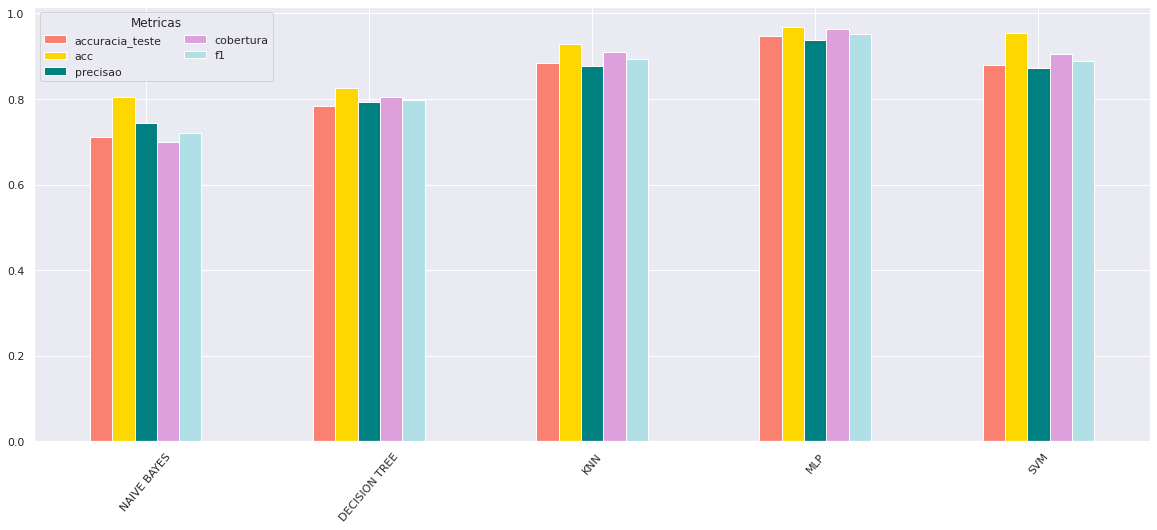

In [60]:
import numpy as np
import pandas as pd

df =  pd.DataFrame.from_dict(
    scores_dict,
    orient="index",
    columns=["accuracia_teste", "acc", "precisao","cobertura", "f1", "matrix_conf"],
)

df.to_csv("Metricas.csv", sep=';')

cor = ['salmon','gold','teal','plum','powderblue']
ax = df.plot(kind='bar', figsize=(20, 8),color = cor, rot=50).legend(
    loc='upper left', ncol=2, title="Metricas"
)
plt.savefig('metricas.png', bbox_inches='tight')

In [61]:
df

,accuracia_teste,acc,precisao,cobertura,f1,matrix_conf
NAIVE BAYES,0.711864,0.804066,0.742718,0.698630,0.720000,"(141, 53, 66, 153)"
DECISION TREE,0.784504,0.825658,0.792793,0.803653,0.798186,"(148, 46, 43, 176)"
KNN,0.883777,0.928125,0.876652,0.908676,0.892377,"(166, 28, 20, 199)"
MLP,0.946731,0.967246,0.937778,0.963470,0.950450,"(180, 14, 8, 211)"
SVM,0.878935,0.953125,0.872247,0.904110,0.887892,"(165, 29, 21, 198)"
